In [356]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import warnings
from pathlib import Path
from v1dd_public import ARTIFACT_DIR
from scipy import stats
from v1dd_public import utils
from allen_v1dd.client import OPhysClient
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.stimulus_analysis import LocallySparseNoise
import statsmodels.stats.multicomp as multi
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import ks_2samp
from allen_v1dd.client import OPhysClient
from itertools import compress

np.random.seed(42) # set seed for reproducibility

In [357]:
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [358]:
def find_subfields(cell, lsn_vals, pvals, design_matrix, response_thresh_alpha=0.01, visualize=False, shuffle=False):
    '''
    Find the subfield of a cell that responds to the LSN stimulus.
    '''
    if shuffle:
        design_matrix = np.random.permutation(design_matrix) # permutes the design matrix to shuffle the stimulus order

    # pull out the LSN values and p-values for the cell
    lsn_vals_cell = lsn_vals[:, cell]
    pvals_cell = pvals[:, cell]

    # find the responsive trials and corresponding stimuli for those trials 
    is_trial_responsive = pvals_cell < response_thresh_alpha
    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 2.5) & (counts_stim_for_resp_trials_on >= 10)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -2.5) & (counts_stim_for_resp_trials_off >= 10)  # threshold for significance

    # check for "islands"
    on_subfield_pixels_all = np.where(on_results == True)
    on_subfield = []
    if on_results.sum() > 1:
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        for x, y in zip(on_subfield_pixels_all[0], on_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                on_subfield.append([x, y])
    elif on_results.sum() == 1:
        on_subfield.append([on_subfield_pixels_all[0][0], on_subfield_pixels_all[1][0]])
    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1
    
    off_subfield_pixels_all = np.where(off_results == True)
    off_subfield = []
    if off_results.sum() > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        for x, y in zip(off_subfield_pixels_all[0], off_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                off_subfield.append([x, y])
    elif off_results.sum() == 1:
        off_subfield.append([off_subfield_pixels_all[0][0], off_subfield_pixels_all[1][0]])
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    if visualize:
        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Responsive Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Responsive Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray_r', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        # axs[1, 3].axis('off')

        return on_subfield, off_subfield, fig

    return on_subfield, off_subfield, None


In [236]:
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


## Pull out some sample on/off subfields

In [360]:
# find On/Off subfield if it exists 
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2
# plane = 3
# plane = 1

s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


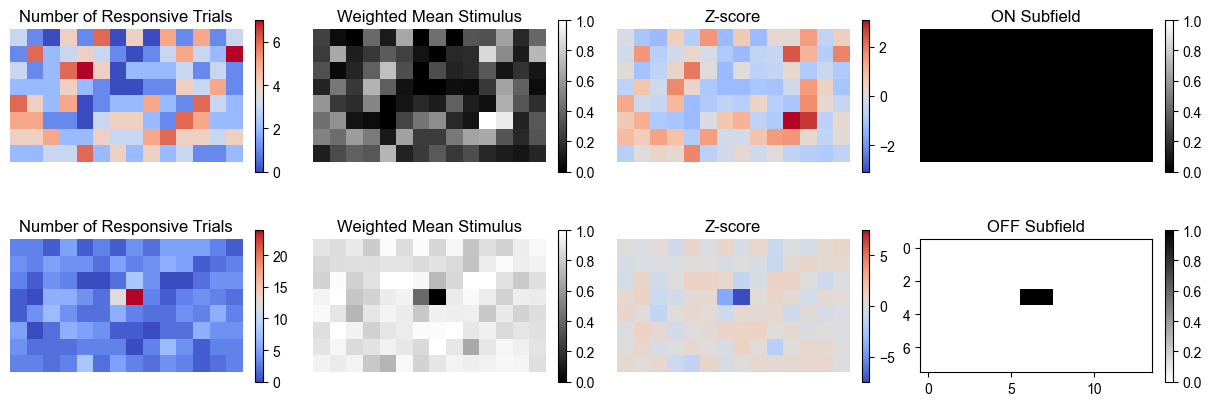

In [361]:
# cell = 305
cell = 194

on_subfield, off_subfield, _ = find_subfields(cell, all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, design_matrix, 0.01, True, False)

plt.savefig(os.path.join(figure_path, f'{mouse_id}_{col_vol_str}_plane_{plane}_cell_{cell}_subfields.svg'), dpi=300, bbox_inches='tight')

## Calculate all ON/OFF subfields across all sessions

In [362]:
base_folder = "/home/naomi/Desktop/data/V1dd_nwbs"
client = OPhysClient(base_folder)
session_ids = client.get_all_session_ids()

In [363]:
def get_mouse_name(mouse_id):

    # Set up mouse id mapping to index metrics dataframe correctly
    mouse_id_mapping = {
        427836: "slc5",
        438833: "slc4",
        416296: "teto1",
        409828: "slc2",
    }

    return mouse_id_mapping[mouse_id]

In [364]:
def select_rois(session, plane, metrics_df=None, unduplicated=False):
    rois = session.get_rois(plane)
    if unduplicated:
        if metrics_df is not None:
            rois = metrics_df[
                (metrics_df["mouse_id"] == get_mouse_name(session.get_mouse_id()))
                & (metrics_df["column"] == str(session.get_column_id()))
                & (metrics_df["volume"] == str(session.get_volume_id()))
                & (metrics_df["plane"] == plane)
            ].cell_index.values
            return list(rois)
        else:
            print("Cannot find any unduplicated ROIs...where is metrics_df")
    else:
        return list(
            compress(
                rois,
                session.is_roi_valid(plane=plane),
            )
        )

In [365]:
ARTIFACT_DIR = Path('/home/naomi/Desktop/code/v1dd-public/artifacts')
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons|
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

#### next code block will run the analysis for both shuffled and normal data, takes ~200 minutes total

In [ ]:
# s1, s2 = 8, 14
# response_thresh_alpha = 0.01
# nstd = 3
# onset_delay = -1
# offset_delay = 2
# sample_spontaneous = 1000

# for shuffle in [False, True]:

#     subfield_results = {
#         'session': [],
#         'mouse_id': [],
#         'depth': [],
#         'cell': [],
#         'on_subfield': [],
#         'off_subfield': [],
#         'on_center_x': [],
#         'on_center_y': [],
#         'off_center_x': [],
#         'off_center_y': [],
#         'on_off_center_distance': [],
#     }
    
#     print(f"Shuffle: {shuffle}")

#     for session_id in session_ids:
#         try:
#             session = client.load_ophys_session(session_id)
#             # print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')
#         except ValueError:
#             # print(f"Error loading session {session_id}")
#             continue

#         for plane in session.get_planes():
#             # print(f'Analyzing plane {plane}')

#             # Check if session has nonduplicated ROIs
#             unduplicated_rois = select_rois(session, plane, metrics_df=cell_info, unduplicated=True)

#             if len(unduplicated_rois) < 1:
#                 # print(f"\tNo unduplicated ROIs found for {session_id} plane {plane}")
#                 continue

#             all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
#                                                 plane,
#                                                 sample_spontaneous,
#                                                 onset_delay,
#                                                 offset_delay)

#             design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

#             if all_lsn_vals_in_colvol_plane.ndim == 1:
#                 all_lsn_vals_in_colvol_plane = all_lsn_vals_in_colvol_plane.reshape(1705, 1)
#                 all_pvals_in_colvol_plane = all_pvals_in_colvol_plane.reshape(1705, 1)

#             elif all_lsn_vals_in_colvol_plane.ndim == 0:
#                 continue

#             for cell in range(all_lsn_vals_in_colvol_plane.shape[1]):

#                 on_subfield, off_subfield, _ = find_subfields(cell, all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, design_matrix, response_thresh_alpha, False, shuffle)

#                 subfield_results['session'].append(session.get_session_id())
#                 subfield_results['mouse_id'].append(session.get_mouse_id())
#                 subfield_results['depth'].append(session.get_plane_depth(plane))
#                 subfield_results['cell'].append(cell_indices[cell])
#                 subfield_results['on_subfield'].append(on_subfield)
#                 subfield_results['off_subfield'].append(off_subfield)

#                 if on_subfield.size > 0:
#                     on_center_x = on_subfield[:, 1].mean()
#                     on_center_y = on_subfield[:, 0].mean()
#                     subfield_results['on_center_x'].append(on_center_x)
#                     subfield_results['on_center_y'].append(on_center_y)
#                 else:
#                     subfield_results['on_center_x'].append(None)
#                     subfield_results['on_center_y'].append(None)
                
#                 if off_subfield.size > 0:
#                     off_center_x = off_subfield[:, 1].mean()
#                     off_center_y = off_subfield[:, 0].mean()
#                     subfield_results['off_center_x'].append(off_center_x)
#                     subfield_results['off_center_y'].append(off_center_y)
#                 else:
#                     subfield_results['off_center_x'].append(None)
#                     subfield_results['off_center_y'].append(None)
                
#                 if on_subfield.size > 0 and off_subfield.size > 0:
#                     on_off_center_distance = np.sqrt((on_center_x - off_center_x)**2 + (on_center_y - off_center_y)**2)
#                     subfield_results['on_off_center_distance'].append(on_off_center_distance)
#                 else:
#                     subfield_results['on_off_center_distance'].append(None)
        
#     subfield_results_df = pd.DataFrame(subfield_results)
#     csv_tag = f"_250324_shuf{shuffle}"
#     subfield_results_df.to_csv(ARTIFACT_DIR / f'subfield_results{csv_tag}.csv', index=False)

Shuffle: False


/tmp/ipykernel_9576/1614489092.py:19: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_9576/1614489092.py:27: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/tmp/ipykernel_9576/1614489092.py:19: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:18

Shuffle: True


/tmp/ipykernel_9576/1614489092.py:19: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_9576/1614489092.py:27: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/tmp/ipykernel_9576/1614489092.py:19: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:18

In [9]:
# subfield_results_df_shuf = pd.read_csv(ARTIFACT_DIR / f'subfield_results_250319_shuf.csv')
# subfield_results_df = pd.read_csv(ARTIFACT_DIR / f'subfield_results_shuf_250318.csv')

subfield_results_df_shuf = pd.read_csv(ARTIFACT_DIR / f'subfield_results_250324_shufTrue.csv')
subfield_results_df = pd.read_csv(ARTIFACT_DIR / f'subfield_results_250324_shufFalse.csv')

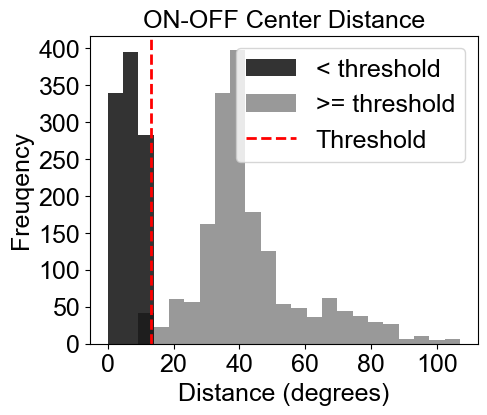

In [ ]:
bins = np.arange(0, 12, 0.5) * 9.3

threshold = np.percentile(subfield_results_df_shuf['on_off_center_distance'].dropna().values, 5)

vals_below_thresh = subfield_results_df[subfield_results_df['on_off_center_distance'] < threshold].on_off_center_distance.dropna().values * 9.3
vals_above_thresh = subfield_results_df[subfield_results_df['on_off_center_distance'] >= threshold].on_off_center_distance.dropna().values * 9.3
shuf_vals = subfield_results_df_shuf['on_off_center_distance'].dropna().values * 9.3

plt.figure(figsize=(5, 4))
plt.hist(vals_below_thresh, bins=bins, color='k', alpha=0.8, label='< threshold')
plt.hist(vals_above_thresh, bins=bins, color='k', alpha=0.4, label='>= threshold')

plt.axvline(threshold * 9.3, color='red', linewidth=2, linestyle='--', label='Threshold')

fontsize=18
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Distance (degrees)', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylabel('Freuqency', fontsize=fontsize)
plt.title('ON-OFF Center Distance', fontsize=fontsize)
plt.savefig(os.path.join(figure_path, 'on_off_subfield_distance.svg'), bbox_inches='tight', dpi=300)

In [125]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
mouse_id_mapping = {
    427836: "slc5",
    438833: "slc4",
    416296: "teto1",
    409828: "slc2",
}
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

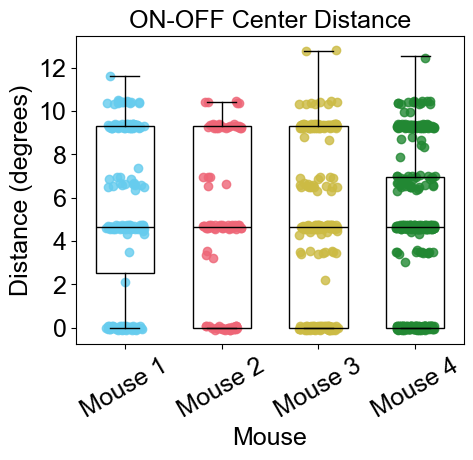

In [131]:
# Plot the ON-OFF subfield distance for each mouse
plt.figure(figsize=(5, 4))

for idx, mouse in enumerate(mouse_ids):
    mouse_data = subfield_results_df[subfield_results_df['mouse_id'] == int(mouse[1:])]
    mouse_data_shuf = subfield_results_df_shuf[subfield_results_df_shuf['mouse_id'] == int(mouse[1:])]

    vals_below_thresh = mouse_data[mouse_data['on_off_center_distance'] < threshold].on_off_center_distance.dropna().values * 9.3

    plt.boxplot(vals_below_thresh, positions=[idx], widths=0.6, 
                patch_artist=True, 
                boxprops={'fill': None}, 
                medianprops=dict(color='k'),
                showfliers=False)

    plt.scatter(np.ones_like(vals_below_thresh)*idx+np.random.uniform(-0.2, 0.2, len(vals_below_thresh)), 
                vals_below_thresh + np.random.uniform(-0.1, 0.1, len(vals_below_thresh)),
                color=mouse_colors[mouse_id_mapping[int(mouse[1:])]], 
                alpha=0.8)

plt.xlabel('Mouse', fontsize=fontsize)
plt.ylabel('Distance (degrees)', fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], fontsize=fontsize, rotation=30)
plt.yticks(fontsize=fontsize)
plt.title('ON-OFF Center Distance', fontsize=fontsize)

plt.savefig(os.path.join(figure_path, 'on_off_subfield_distance_mice.svg'), bbox_inches='tight', dpi=300)

In [132]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = 4
sample_size = 50
bootstrapped_data = np.zeros((n_bootstrap, n_mice, n_z_groups))

for z, z_group in enumerate(z_groups_high_to_low):
    for m, mouse in enumerate(subfield_results_df['mouse_id'].unique()):
        data = subfield_results_df[(subfield_results_df['mouse_id'] == mouse) & (subfield_results_df['depth'].isin(z_group))]['on_center_x'].values
        if len(data) < 1:
            for b in range(n_bootstrap):
                bootstrapped_data[b, m, z] = np.nan
            continue
        for b in range(n_bootstrap):
            sample = np.random.choice(data, size=sample_size, replace=True)
            percent_on = len(sample[~np.isnan(sample)]) / 50
            bootstrapped_data[b, m, z] = percent_on

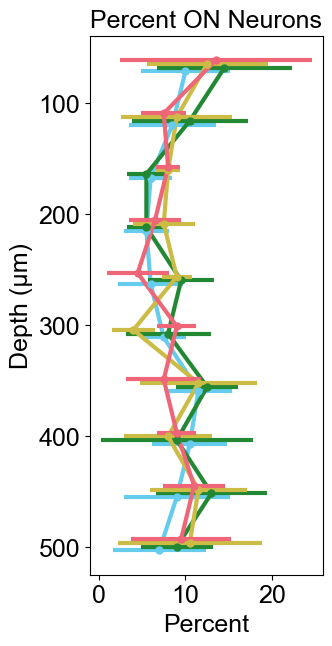

In [138]:
plt.figure(figsize=(3, 7))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for m, mouse in enumerate(mice):
    means = []
    std_errors = []
    mouse_color = mouse_colors[mice[m]]

    for z in range(n_z_groups):
        bootstrapped_values = bootstrapped_data[m, :, z] * 100
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    jitter = fixed_jitters[:, 3-m]
    y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter

    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, capsize=0, markersize=5, linewidth=3)
    plt.plot(means, y_positions, linewidth=3, color=mouse_color)

plt.xlabel('Percent', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('Percent ON Neurons', fontsize=fontsize)
plt.savefig(os.path.join(figure_path, 'percent_on_neurons.svg'), bbox_inches='tight', dpi=300)

In [158]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = 4
sample_size = 50
bootstrapped_data = np.zeros((n_bootstrap, n_mice, n_z_groups))

for z, z_group in enumerate(z_groups_high_to_low):
    for m, mouse in enumerate(subfield_results_df['mouse_id'].unique()):
        data = subfield_results_df[(subfield_results_df['mouse_id'] == mouse) & (subfield_results_df['depth'].isin(z_group))]['off_center_x'].values
        if len(data) < 1:
            for b in range(n_bootstrap):
                bootstrapped_data[b, m, z] = np.nan
            continue
        for b in range(n_bootstrap):
            sample = np.random.choice(data, size=sample_size, replace=True)
            percent_on = len(sample[~np.isnan(sample)]) / 50
            bootstrapped_data[b, m, z] = percent_on

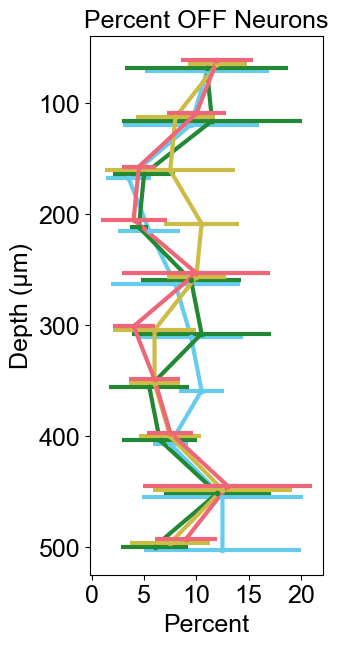

In [159]:
plt.figure(figsize=(3, 7))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for m, mouse in enumerate(mice):
    means = []
    std_errors = []
    mouse_color = mouse_colors[mice[m]]

    for z in range(n_z_groups):
        bootstrapped_values = bootstrapped_data[m, :, z] * 100
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    jitter = fixed_jitters[:, 3-m]
    y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter

    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, capsize=0, markersize=3, linewidth=3)
    plt.plot(means, y_positions, linewidth=3, color=mouse_color)

plt.xlabel('Percent', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('Percent OFF Neurons', fontsize=fontsize)
plt.savefig(os.path.join(figure_path, 'percent_off_neurons.svg'), bbox_inches='tight', dpi=300)

In [156]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = 4
sample_size = 50
bootstrapped_data = np.zeros((n_bootstrap, n_mice, n_z_groups))

for z, z_group in enumerate(z_groups_high_to_low):
    for m, mouse in enumerate(subfield_results_df['mouse_id'].unique()):
        data = subfield_results_df[(subfield_results_df['mouse_id'] == mouse) & (subfield_results_df['depth'].isin(z_group))]['on_off_center_distance'].dropna().values
        data = data[data < threshold]
        
        if len(data) < 1:
            for b in range(n_bootstrap):
                bootstrapped_data[b, m, z] = np.nan
            continue
        for b in range(n_bootstrap):
            bootstrapped_data[b, m, z] = np.random.choice(data, size=sample_size, replace=True).mean()

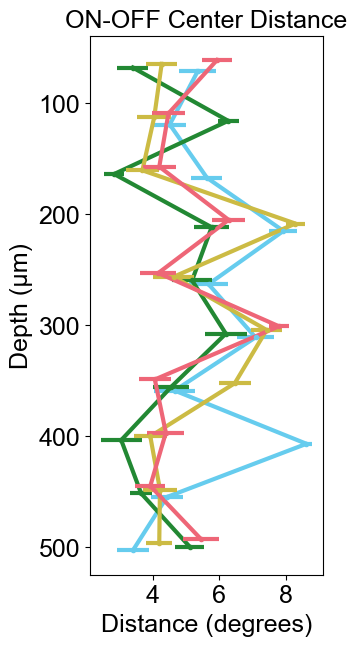

In [157]:
plt.figure(figsize=(3, 7))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for m, mouse_id in enumerate(mice):
    means = []
    std_errors = []
    mouse_color = mouse_colors[mice[m]]
    
    for z in range(n_z_groups):
        bootstrapped_values = bootstrapped_data[:, m, z] * 9.3
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    jitter = fixed_jitters[:, 3-m]
    y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter
    
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3, linewidth=3)
    plt.plot(means, y_positions, color=mouse_color, linewidth=3)

plt.xlabel('Distance (degrees)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('ON-OFF Center Distance', fontsize=fontsize)
plt.savefig(os.path.join(figure_path, 'on_off_center_distance_by_depth.svg'), bbox_inches='tight', dpi=300)

In [144]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = 4
sample_size = 50
bootstrapped_data = np.zeros((n_bootstrap, n_mice, n_z_groups))

for z, z_group in enumerate(z_groups_high_to_low):
    for m, mouse in enumerate(subfield_results_df['mouse_id'].unique()):
        data = subfield_results_df[(subfield_results_df['mouse_id'] == mouse) & (subfield_results_df['depth'].isin(z_group))]['on_off_center_distance'].values
        if len(data) < 1:
            for b in range(n_bootstrap):
                bootstrapped_data[b, m, z] = np.nan
            continue
        for b in range(n_bootstrap):
            sample = np.random.choice(data, size=sample_size, replace=True)
            percent_on_and_off = len(sample[~np.isnan(sample)]) / 50
            bootstrapped_data[b, m, z] = percent_on_and_off


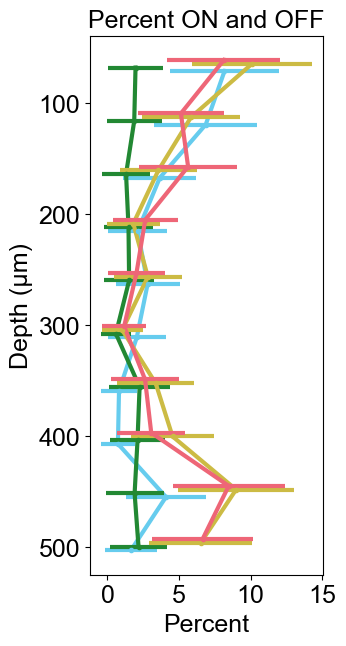

In [146]:
plt.figure(figsize=(3, 7))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for m, mouse_id in enumerate(mice):
    means = []
    std_errors = []
    mouse_color = mouse_colors[mice[m]]
    
    for z in range(n_z_groups):
        bootstrapped_values = bootstrapped_data[:, m, z] * 100
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    jitter = fixed_jitters[:, 3-m]
    y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter
    
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3, linewidth=3)
    plt.plot(means, y_positions, color=mouse_color, linewidth=3)

plt.xlabel('Percent', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('Percent ON and OFF', fontsize=fontsize)
plt.savefig(os.path.join(figure_path, 'percent_on_and_off_neurons.svg'), bbox_inches='tight', dpi=300)

In [ ]:
on_subfield_vals = subfield_results_df['on_subfield'].dropna().values
off_subfield_vals = subfield_results_df['off_subfield'].dropna().values

shape_counts = np.zeros(6)
# shape 1 = 1 pixel
# shape 2 = 2 pixels, horizontal bar
# shape 3 = 2 pixels, vertical bar
# shape 4 = 2 pixels, diagonal (45 degrees)
# shape 5 = 2 pixels, diagonal (135 degrees)
# shape 6 = 3+ pixels

for on_sub in on_subfield_vals:
    if len(on_sub) > 2:
        on_sub = on_sub.replace('[', '').replace(']', '').replace('\n', '')
        on_sub = on_sub.split(' ')
    else:
        continue

    on_sub = [int(x) for x in on_sub if x != '']
    on_sub = np.array(on_sub).astype(int)
    print(on_sub)

    x_vals = on_sub[::2]
    y_vals = on_sub[1::2]

    if len(x_vals) == 1:
        print('one pixel')
        shape_counts[0] += 1
    elif len(x_vals) == 2:
        # print(x_vals, y_vals)
        if x_vals[0] == x_vals[1]:
            print('horizontal bar')
            shape_counts[2] += 1
        elif y_vals[0] == y_vals[1]:
            print('vertical bar')
            shape_counts[1] += 1
        elif (x_vals[0] - x_vals[1]) / (y_vals[0] - y_vals[1]) == 1:
            print('45 degree diagonal')
            shape_counts[3] += 1
        else:
            print('135 degree diagonal')
            shape_counts[4] += 1
    else:
        print('3+ pixels')
        shape_counts[5] += 1

[5 8]
one pixel
[2 5]
one pixel
[3 5]
one pixel
[2 5 3 6]
45 degree diagonal
[2 5]
one pixel
[3 6]
one pixel
[2 7]
one pixel
[3 5 3 4 4 4]
3+ pixels
[4 4 4 5]
vertical bar
[6 7]
one pixel
[2 4]
one pixel
[2 6]
one pixel
[1 9]
one pixel
[7 5]
one pixel
[2 4]
one pixel
[3 6]
one pixel
[2 5 2 4 2 6]
3+ pixels
[6 7]
one pixel
[2 5 2 4]
vertical bar
[2 6]
one pixel
[3 3]
one pixel
[2 4]
one pixel
[2 4]
one pixel
[2 5]
one pixel
[2 5]
one pixel
[2 5]
one pixel
[5 0]
one pixel
[3 5 2 5]
horizontal bar
[2 4 2 5]
vertical bar
[2 6 2 5]
vertical bar
[2 5 2 4]
vertical bar
[ 2 10]
one pixel
[7 5]
one pixel
[3 6]
one pixel
[2 5]
one pixel
[2 5]
one pixel
[ 3 12]
one pixel
[6 0]
one pixel
[3 8 3 7]
vertical bar
[2 5]
one pixel
[2 4]
one pixel
[2 7]
one pixel
[7 5]
one pixel
[2 5]
one pixel
[7 5]
one pixel
[3 5 2 5 3 6]
3+ pixels
[2 9]
one pixel
[3 5 3 6]
vertical bar
[ 2 10]
one pixel
[2 5]
one pixel
[3 2 3 3]
vertical bar
[5 2]
one pixel
[1 6 1 5]
vertical bar
[2 4]
one pixel
[3 6]
one pixel
[3 2]

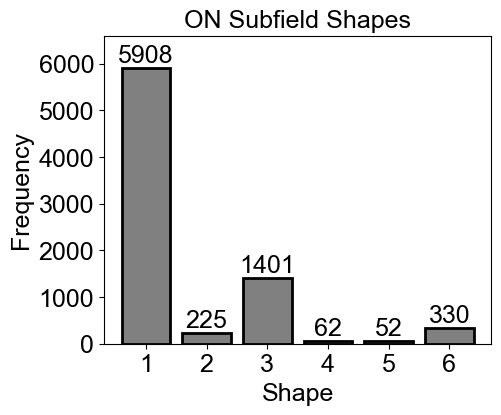

In [229]:
plt.figure(figsize=(5, 4))
plt.bar(np.arange(1, 7), height=shape_counts, color='grey', linewidth=2, edgecolor='k')
plt.xlabel('Shape', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('ON Subfield Shapes', fontsize=fontsize)

for i in range(6):
    plt.text(i+1, shape_counts[i]+120, str(int(shape_counts[i])), fontsize=fontsize, ha='center')

plt.ylim(0, 6600)
plt.savefig(os.path.join(figure_path, 'on_subfield_shapes.svg'), bbox_inches='tight', dpi=300)

In [ ]:
off_subfield_vals = subfield_results_df['off_subfield'].dropna().values

shape_counts = np.zeros(6)
# shape 1 = 1 pixel
# shape 2 = 2 pixels, horizontal bar
# shape 3 = 2 pixels, vertical bar
# shape 4 = 2 pixels, diagonal (45 degrees)
# shape 5 = 2 pixels, diagonal (135 degrees)
# shape 6 = 3+ pixels

for off_sub in off_subfield_vals:
    if len(off_sub) > 2:
        off_sub = off_sub.replace('[', '').replace(']', '').replace('\n', '')
        off_sub = off_sub.split(' ')
    else:
        continue

    off_sub = [int(x) for x in off_sub if x != '']
    off_sub = np.array(off_sub).astype(int)
    print(off_sub)

    x_vals = off_sub[::2]
    y_vals = off_sub[1::2]

    if len(x_vals) == 1:
        print('one pixel')
        shape_counts[0] += 1
    elif len(x_vals) == 2:
        # print(x_vals, y_vals)
        if x_vals[0] == x_vals[1]:
            print('horizontal bar')
            shape_counts[2] += 1
        elif y_vals[0] == y_vals[1]:
            print('vertical bar')
            shape_counts[1] += 1
        elif (x_vals[0] - x_vals[1]) / (y_vals[0] - y_vals[1]) == 1:
            print('45 degree diagonal')
            shape_counts[3] += 1
        else:
            print('135 degree diagonal')
            shape_counts[4] += 1
    else:
        print('3+ pixels')
        shape_counts[5] += 1

[2 5]
one pixel
[2 6]
one pixel
[4 4]
one pixel
[3 5 2 5 3 4]
3+ pixels
[2 6]
one pixel
[2 5]
one pixel
[2 3]
one pixel
[2 5 2 6]
vertical bar
[2 5]
one pixel
[3 4]
one pixel
[2 5]
one pixel
[3 5]
one pixel
[3 5]
one pixel
[2 7]
one pixel
[3 4 2 4 4 4]
3+ pixels
[2 7]
one pixel
[ 7 10]
one pixel
[2 6]
one pixel
[5 7]
one pixel
[2 5]
one pixel
[2 5]
one pixel
[3 5 2 5 3 4]
3+ pixels
[2 5 1 4 2 6 3 6]
3+ pixels
[3 3]
one pixel
[ 5 10]
one pixel
[ 1 10]
one pixel
[2 3 1 3 2 2]
3+ pixels
[2 5]
one pixel
[3 4 2 5 3 5]
3+ pixels
[2 5]
one pixel
[ 0 10]
one pixel
[3 4 3 3]
vertical bar
[2 4]
one pixel
[3 5]
one pixel
[3 6]
one pixel
[2 3]
one pixel
[2 5 2 4 3 4]
3+ pixels
[1 5]
one pixel
[2 5]
one pixel
[3 5]
one pixel
[0 9]
one pixel
[3 3 2 2 2 3 3 2]
3+ pixels
[3 5]
one pixel
[7 2]
one pixel
[1 7]
one pixel
[2 6 2 5]
vertical bar
[2 6]
one pixel
[1 5 1 4]
vertical bar
[ 7 10]
one pixel
[2 5]
one pixel
[2 5 2 4 3 5]
3+ pixels
[2 6]
one pixel
[3 4 2 5 3 5]
3+ pixels
[3 5]
one pixel
[3 4 3 3]


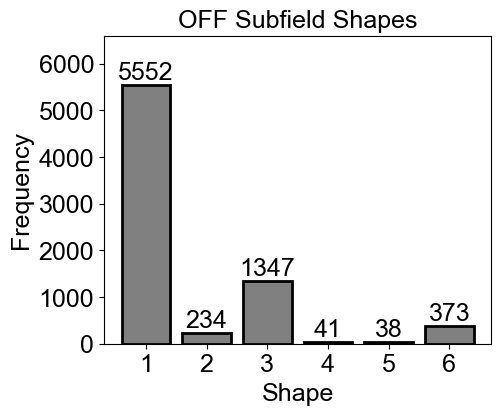

In [232]:
plt.figure(figsize=(5, 4))
plt.bar(np.arange(1, 7), height=shape_counts, color='grey', linewidth=2, edgecolor='k')
plt.xlabel('Shape', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('OFF Subfield Shapes', fontsize=fontsize)

for i in range(6):
    plt.text(i+1, shape_counts[i]+120, str(int(shape_counts[i])), fontsize=fontsize, ha='center')

plt.ylim(0, 6600)
plt.savefig(os.path.join(figure_path, 'off_subfield_shapes.svg'), bbox_inches='tight', dpi=300)